In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import arviz as az
import warnings
from cmdstanpy import cmdstan_path, CmdStanModel

In [2]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "stan_rct"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%config InlineBackend.figure_format = "retina"

In [3]:
stan_file = os.path.join('stan', 'rct.stan')
with open(stan_file, 'r') as f:
    print(f.read())

data {
  int<lower=0> Nb;  // # obs in RCT treatment B
  int<lower=0> Nh;  // # obs in historical control data
  vector[Nb] yb;    // vector of tx=B data
  vector[Nh] yh;    // vector of historical data
  real<lower=0> sigma;  // standard deviation of prior for bias
}
parameters {
  real mua;  // unknown mean for tx=A
  real mub;  // unknown mean for tx=B
  real bias; // unknown bias
}
transformed parameters {
  real delta;
  delta = mua - mub;
}
model {
  yb   ~ normal(mub, 1.0);
  yh   ~ normal(mua + bias, 1.0);
  bias ~ normal(0., sigma);
}




In [4]:
model = CmdStanModel(stan_file=stan_file)

In [5]:
Na = 20
Nb = 40
Nh = 500
ya = rng.normal(loc=10, scale=1, size=Na)
yb = rng.normal(loc=5, scale=1, size=Nb)
yh = rng.normal(loc=20, scale=1, size=Nh)

In [6]:
stan_data = {
    "Nb" : Nb, 
    "Nh" : Nh, 
    "yb" : yb, 
    "yh" : yh,
    "sigma" : 1.0
}

In [7]:
fit = model.sample(data=stan_data)

09:49:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:49:56 - cmdstanpy - INFO - CmdStan done processing.


In [8]:
print(fit.summary())

            Mean      MCSE    StdDev         5%         50%        95%  \
lp__  -264.44900  0.035496  1.194000 -266.85100 -264.153000 -263.12400   
mua     19.96750  0.031945  0.987698   18.30840   19.977100   21.57230   
mub      5.20393  0.003939  0.161558    4.93481    5.205210    5.47048   
bias    -0.01375  0.031937  0.986492   -1.62647   -0.022246    1.65250   
delta   14.76350  0.032078  1.001740   13.08890   14.775300   16.39420   

          N_Eff  N_Eff/s    R_hat  
lp__   1131.500  3025.41  1.00148  
mua     955.960  2556.04  1.00570  
mub    1682.640  4499.03  1.00196  
bias    954.092  2551.05  1.00575  
delta   975.225  2607.55  1.00521  


In [9]:
az.summary(fit, var_names=(["bias", "delta"]), hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bias,-0.014,0.986,-1.822,1.950,0.032,0.023,965.0,1031.0,1.01
delta,14.764,1.002,12.767,16.603,0.032,0.023,989.0,1118.0,1.01


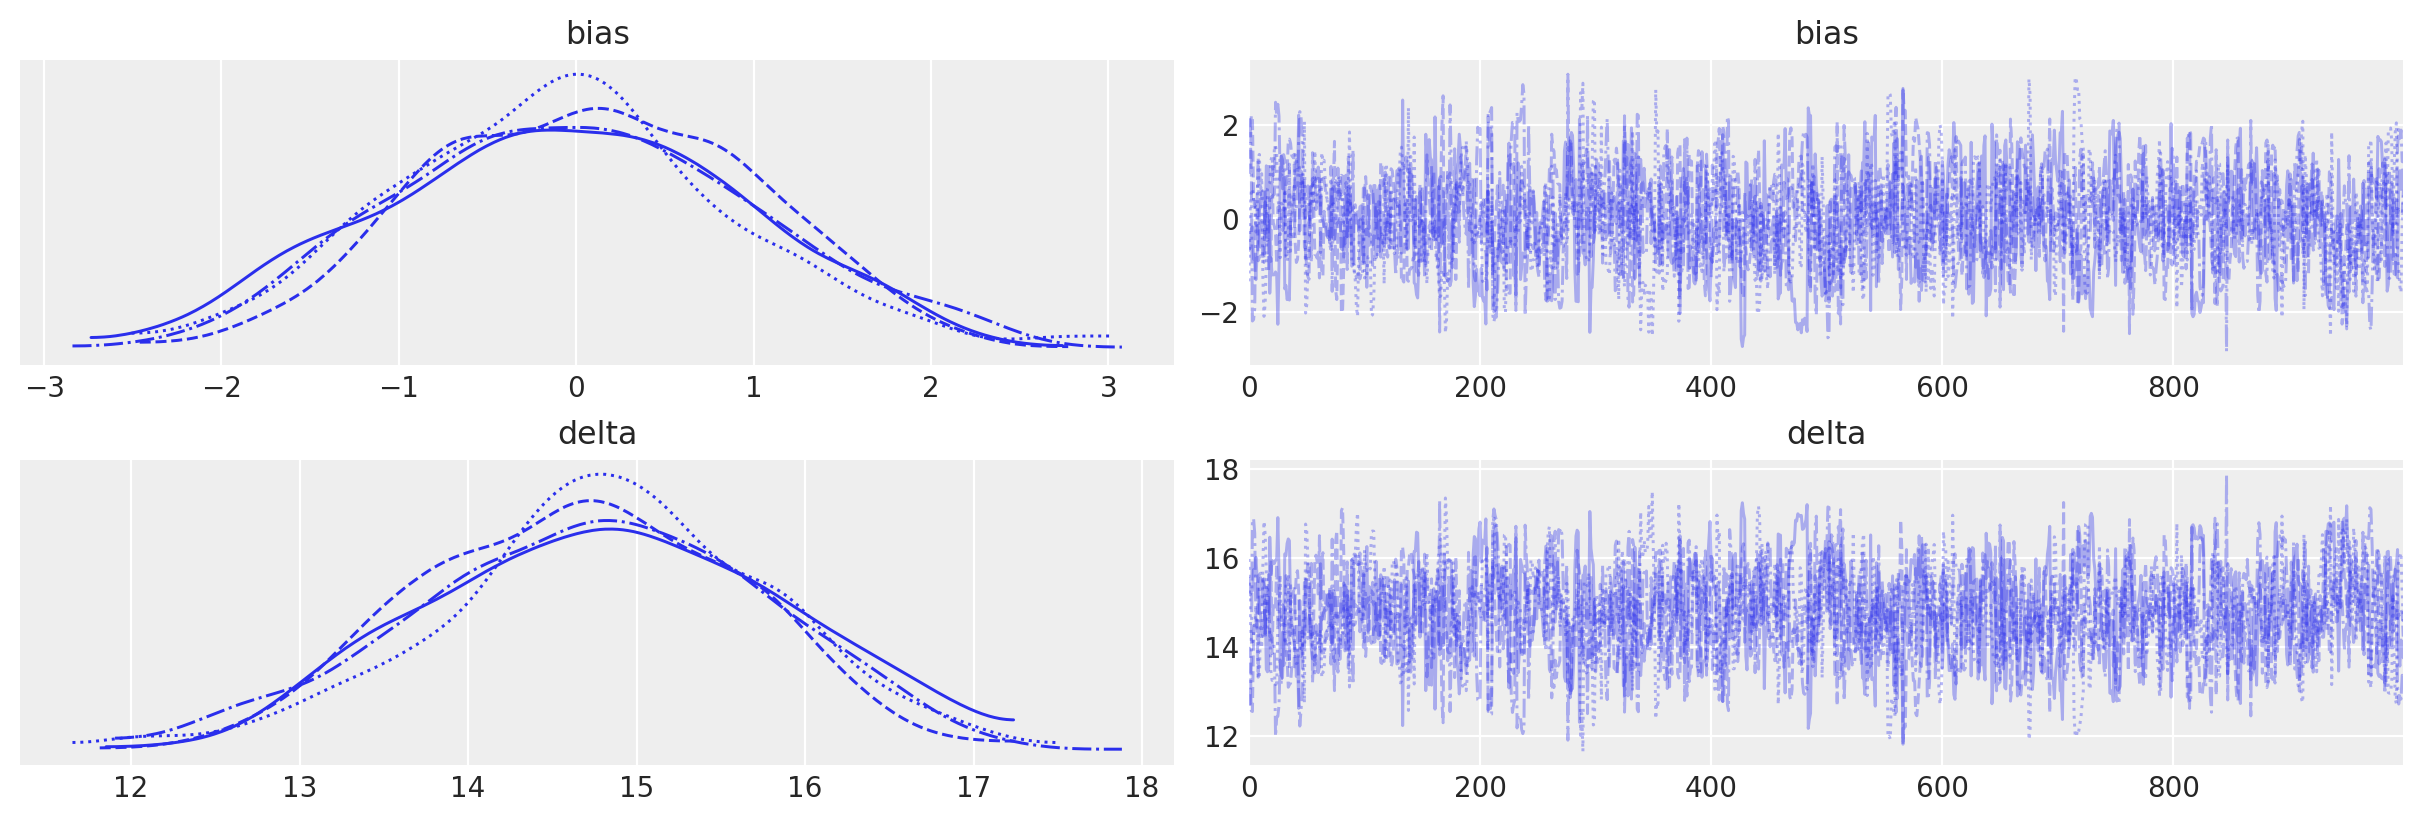

In [10]:
_ = az.plot_trace(fit, var_names=(["bias", "delta"]))

In [11]:
stan_data = {
    "Nb" : Nb, 
    "Nh" : Nh, 
    "yb" : yb, 
    "yh" : yh,
    "sigma" : 0.25
}

In [12]:
fit1 = model.sample(data=stan_data)

09:49:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:49:57 - cmdstanpy - INFO - CmdStan done processing.


In [13]:
az.summary(fit1, var_names=(["bias", "delta"]), hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bias,-0.005,0.252,-0.503,0.501,0.007,0.005,1279.0,1397.0,1.0
delta,14.760,0.300,14.217,15.361,0.008,0.006,1387.0,1525.0,1.0


In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w -m -p cmdstanpy

Last updated: Sun Jun 16 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

cmdstanpy: 1.2.3

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

scipy     : 1.13.1
seaborn   : 0.13.2
matplotlib: 3.8.4
numpy     : 1.26.4
arviz     : 0.18.0
pandas    : 2.2.2

Watermark: 2.4.3

